# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

import pdb

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.3


In [25]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [26]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [27]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

# Let's substract 0.1 instead of 0.2 from the Kaplan Meier survival scores 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


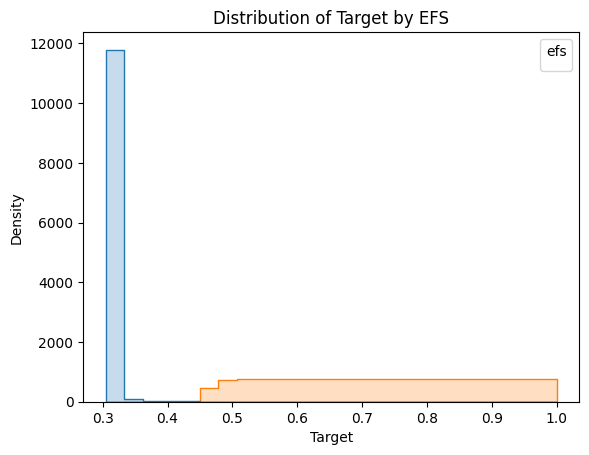

In [28]:
SUBTRACT_KP_SCORE = 0.15

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

# Let's convert year_hct to year_hct_from_baseline to avoid a big difference in scale

In [29]:
MIN_YEAR = train['year_hct'].min() # 2008
train['year_hct_relative'] = train['year_hct'] - MIN_YEAR
train.drop(columns=['year_hct'], inplace=True)

test['year_hct_relative'] = test['year_hct'] - MIN_YEAR
test.drop(columns=['year_hct'], inplace=True)   

test_balanced['year_hct_relative'] = test_balanced['year_hct'] - MIN_YEAR   
test_balanced.drop(columns=['year_hct'], inplace=True)  


In [30]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [31]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [32]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [33]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [34]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# Custom Loss

In [69]:
def custom_equity_loss(race_groups):
    """
    Returns a custom objective function for XGBoost that applies group-level 
    weighting to the standard squared error loss. This function assumes a loss 
    of 0.5*(pred - y)^2 and scales the gradient and Hessian for each sample i 
    in group g by 1/(n_g * num_groups).

    Parameters:
      race_groups: 1D numpy array of race group labels in the exact order 
                   corresponding to the training data that XGBoost sees.
                   
    Returns:
      A callable function (preds, dtrain) -> (grad, hess)
    """
    # Get the unique group labels and count them.
    unique_groups = np.unique(race_groups)
    num_groups = len(unique_groups)
    # Compute the count of samples in each group.
    group_counts = {g: np.sum(race_groups == g) for g in unique_groups}
    # For each sample, compute the scaling factor = 1/(n_g * num_groups)
    factors = np.array([1.0 / (group_counts[r] * num_groups) for r in race_groups])
    # pdb.set_trace()
    def loss(preds, dtrain):
        pdb.set_trace()
        # dtrain.get_label() returns the labels in the same order as the training data.
        y = dtrain.get_label()
        # Compute gradient and hessian.
        grad = factors * (preds - y)
        hess = factors  # constant for each sample.
        return grad, hess
    return loss

In [73]:
def custom_equity_loss(race_groups):
    """
    Vectorized custom objective function for XGBoost that approximates a 
    stratified c-index using a pairwise logistic loss computed within each race group.

    Parameters:
        race_groups (np.array): 1D array of race_group values corresponding to 
                                the training samples.
    """
    unique_groups, group_indices = np.unique(race_groups, return_inverse=True)

    def loss_fn(preds, dtrain):
        labels = dtrain.get_label()
        grad = np.zeros_like(preds)
        hess = np.zeros_like(preds)
        alpha = 1.0  # Scaling factor (can be tuned)

        # Process each race group efficiently
        for group in np.unique(group_indices):
            indices = np.where(group_indices == group)[0]
            if len(indices) < 2:
                continue  # Skip small groups
            
            group_preds = preds[indices][:, np.newaxis]  # Shape (N, 1)
            group_labels = labels[indices][:, np.newaxis]  # Shape (N, 1)

            # Compute all pairwise differences at once
            label_diff = group_labels - group_labels.T  # Shape (N, N)
            pred_diff = group_preds - group_preds.T  # Shape (N, N)
            
            # Only keep comparisons where labels differ
            valid_pairs = label_diff != 0
            margin = alpha * label_diff * pred_diff
            exp_neg_margin = np.exp(-margin)
            sigma = exp_neg_margin / (1.0 + exp_neg_margin)
            
            # Compute gradients and Hessians in a vectorized manner
            pair_grad = -alpha * label_diff * sigma
            pair_hess = alpha**2 * (label_diff**2) * sigma * (1 - sigma)

            # Sum contributions for each sample
            grad[indices] = np.sum(pair_grad * valid_pairs, axis=1)
            hess[indices] = np.sum(pair_hess * valid_pairs, axis=1)

        return grad, hess

    return loss_fn


# XGBoost with custom loss function

In [74]:
# Prepare the out-of-fold DataFrame to store predictions and additional metadata.
oof_xgb = train[['kfold', 'ID', 'efs', 'efs_time', 'label', 'race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame({'feature': FEATURES})
metric_df = []

for fold in range(skf.n_splits):
    # Split into training and validation sets.
    x_train_full = train[train.kfold != fold].copy()
    x_valid_full = train[train.kfold == fold].copy()
    
    y_train = x_train_full['label'].values
    y_valid = x_valid_full['label'].values
    
    # Extract race group info for the training set
    race_groups_train = x_train_full['race_group'].values

    # Convert training and validation data into DMatrix format
    dtrain = xgb.DMatrix(x_train_full[FEATURES], label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(x_valid_full[FEATURES], label=y_valid, enable_categorical=True)

    # Create the custom objective function
    custom_obj = custom_equity_loss(race_groups_train)

    # Define XGBoost parameters (excluding objective, since it's custom)
    # Define XGBoost parameters (excluding objective, since it's custom)
    params = {
        "tree_method": "hist",
        "max_depth": 3,
        "colsample_bytree": 0.5, 
        "subsample": 0.8, 
        "learning_rate": 0.03,
        "min_child_weight": 5,
        "eval_metric": "auc",  # Just to monitor performance
        "disable_default_eval_metric": True
    }

    # Train the model using XGBoost's native API (not XGBRegressor)
    clf = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        evals=[(dvalid, "validation")],
        obj=custom_obj,
        early_stopping_rounds=100,
        verbose_eval=500
    )

    # Store feature importance
    feature_importances_xgb[f'fold_{fold + 1}'] = clf.get_score()

    # Predict on validation fold and store predictions
    preds_valid = clf.predict(dvalid)
    # pdb.set_trace()
    oof_xgb.loc[oof_xgb.kfold == fold, 'prediction'] = preds_valid

    # Save model
    clf.save_model(f"xgb/xgb_model_custom_loss_{fold}.bin")

    # Evaluate custom metric
    y_true = oof_xgb.loc[oof_xgb.kfold == fold, ["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold == fold, ["ID", "prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

[0]	validation-auc:0.57293
[500]	validation-auc:0.62155
[1000]	validation-auc:0.62569
[1465]	validation-auc:0.62647
# c-index=0.6728, mean=0.6871 std=0.0143
[0]	validation-auc:0.57633
[500]	validation-auc:0.62144
[1000]	validation-auc:0.62485
[1500]	validation-auc:0.62571
[1811]	validation-auc:0.62558
# c-index=0.6741, mean=0.6902 std=0.0161
[0]	validation-auc:0.57554
[500]	validation-auc:0.62042
[1000]	validation-auc:0.62177
[1287]	validation-auc:0.62186
# c-index=0.6772, mean=0.6833 std=0.0061
[0]	validation-auc:0.57299
[500]	validation-auc:0.61747
[1000]	validation-auc:0.61991
[1424]	validation-auc:0.62017
# c-index=0.6682, mean=0.6814 std=0.0132
[0]	validation-auc:0.57284
[500]	validation-auc:0.62182
[1000]	validation-auc:0.62410
[1491]	validation-auc:0.62451
# c-index=0.6768, mean=0.6868 std=0.0101


In [75]:

def evaluate_test_set(test_set, model_prefix, skf, FEATURES, custom_score, dataset_name="test set"):
    """
    Evaluate the model on a given test set (imbalanced or balanced).
    
    Parameters:
        test_set (pd.DataFrame): The test set to evaluate.
        model_prefix (str): Prefix for the saved model filenames.
        skf (StratifiedKFold): Cross-validation object to determine the number of folds.
        FEATURES (list): List of feature columns.
        custom_score (function): Function to compute custom evaluation metric.
        dataset_name (str): Name of the dataset for logging purposes.
    
    Returns:
        None (prints evaluation results)
    """
    print(f"Evaluating on {dataset_name}...")

    # Ensure the test set has the required feature columns
    if not set(FEATURES).issubset(test_set.columns):
        raise ValueError(f"{dataset_name} does not have all required feature columns.")

    # Initialize an array to accumulate predictions from each fold
    test_predictions = np.zeros(len(test_set))

    # Initialize a dictionary to store the evaluation metric for each fold
    metric_df = []

    # Loop over folds, load each saved model, and predict on the test set
    for fold in range(skf.n_splits):
        model_filename = f"xgb/{model_prefix}_{fold}.bin"
        clf = XGBRegressor()  # We only use this to load the saved booster
        clf.load_model(model_filename)
        fold_pred = clf.predict(test_set[FEATURES])
        test_set[f'prediction_{fold}'] = fold_pred

        # If labels exist, compute the custom metric for this fold
        if "label" in test_set.columns:
            y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
            y_pred_test = test_set[["ID", f"prediction_{fold}"]].copy().reset_index(drop=True)
            m, metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label=f"prediction_{fold}")
            print(f"{dataset_name} evaluation metric for fold {fold}:", metric_dict)
            metric_df.append(metric_dict)

        test_predictions += fold_pred

    # Average the predictions across folds
    test_predictions /= skf.n_splits
    test_set['ensemble_prediction'] = test_predictions

    print('\nENSEMBLE:')
    # If labels exist, compute the custom metric for an ensemble
    if "label" in test_set.columns:
        y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
        y_pred_test = test_set[["ID", "ensemble_prediction"]].copy().reset_index(drop=True)
        m, ensemble_metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label="ensemble_prediction")
        print(f"{dataset_name} evaluation metric:", metric_dict)
    else:
        print(f"{dataset_name} predictions computed. No labels available for evaluation.")
    return ensemble_metric_dict, metric_df


# Evaluation on full test set

In [76]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
                                                                         "xgb_model_custom_loss", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6550, mean=0.6679 std=0.0129
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6914655840897688, 'Asian': 0.6713611320797233, 'Black or African-American': 0.6540248502802583, 'More than one race': 0.6633042751511915, 'Native Hawaiian or other Pacific Islander': 0.6540936985481215, 'White': 0.673406935096627}
# c-index=0.6566, mean=0.6707 std=0.0140
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6962892852255622, 'Asian': 0.6724990704958482, 'Black or African-American': 0.6546109417957844, 'More than one race': 0.6690733496616328, 'Native Hawaiian or other Pacific Islander': 0.6553947474468355, 'White': 0.6762309599716614}
# c-index=0.6578, mean=0.6698 std=0.0120
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6902682114674087, 'Asian': 0.6697161913989883, 'Black or African-American': 0.6539715692333923, 'More than one race': 

In [77]:
display_overall(pd.DataFrame(balanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6915,0.6963,0.6903,0.6905,0.6965,0.6930
Asian,0.6714,0.6725,0.6697,0.6716,0.6694,0.6709
Black or African-American,0.6540,0.6546,0.6540,0.6512,0.6563,0.6540
More than one race,0.6633,0.6691,0.6684,0.6644,0.6724,0.6675
Native Hawaiian or other Pacific Islander,0.6541,0.6554,0.6587,0.6608,0.6539,0.6566
White,0.6734,0.6762,0.6780,0.6772,0.6738,0.6757
mean,0.668,0.671,0.670,0.669,0.670,0.670
std,0.013,0.014,0.012,0.013,0.014,0.013
score,0.655,0.657,0.658,0.657,0.656,0.657


# Evaluation on imbalanced test subset

In [79]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, "xgb_model_custom_loss", 
                                                                             skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5790, mean=0.6383 std=0.0593
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6859756097560976, 'Asian': 0.6604332953249715, 'Black or African-American': 0.6329712554496416, 'More than one race': 0.5106215578284815, 'Native Hawaiian or other Pacific Islander': 0.6661698956780924, 'White': 0.673406935096627}
# c-index=0.5866, mean=0.6408 std=0.0542
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6880081300813008, 'Asian': 0.6563283922462941, 'Black or African-American': 0.6280573413138255, 'More than one race': 0.5271439811172305, 'Native Hawaiian or other Pacific Islander': 0.669150521609538, 'White': 0.6762309599716614}
# c-index=0.5803, mean=0.6427 std=0.0624
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6869918699186992, 'Asian': 0.6581527936145952, 'Black or African-American': 0.6390674647158797, 'More than one 

In [80]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6860,0.6880,0.6870,0.6809,0.6911,0.6866
Asian,0.6604,0.6563,0.6582,0.6582,0.6513,0.6569
Black or African-American,0.6330,0.6281,0.6391,0.6330,0.6364,0.6339
More than one race,0.5106,0.5271,0.5083,0.4957,0.5264,0.5136
Native Hawaiian or other Pacific Islander,0.6662,0.6692,0.6855,0.6714,0.6773,0.6739
White,0.6734,0.6762,0.6780,0.6772,0.6738,0.6757
mean,0.638,0.641,0.643,0.636,0.643,0.640
std,0.059,0.054,0.062,0.065,0.055,0.059
score,0.579,0.587,0.580,0.571,0.588,0.581


In [ ]:
test['race_group'].value_counts(normalize=True)

race_group
White                                        0.456954
Black or African-American                    0.245033
Asian                                        0.108798
American Indian or Alaska Native             0.081362
More than one race                           0.053926
Native Hawaiian or other Pacific Islander    0.053926
Name: proportion, dtype: float64

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")